<a href="https://colab.research.google.com/github/hcarlens/DQN/blob/master/Simple_DQN_on_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary packages
import numpy as np
import pandas as pd
import gym
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import deque
%matplotlib notebook

In [27]:
# set hyperparameters (mostly taken from DQN paper)
num_episodes = 500
max_num_steps = 200
start_epsilon = 1
end_epsilon = 0.01
epsilon_decay_rate = 0.99
discount_rate = 0.99
batch_size = 32
optimizer_learning_rate = 0.00025
buffer_length = 50000
target_update_steps = 1000
timestep_to_start_learning = 1000

# observed standard deviations on an earlier training run
stddevs = [0.686056, 0.792005, 0.075029, 0.414541]

In [3]:
# make Jupyter notebook appear wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [25]:
# define Q-network (two layers with 32 neurons each)
# 4 inputs (one for each scalar observable) +1 to represent the action
# todo: change to 4 inputs; 5 outputs to require fewer forward passes
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu,
                       input_shape=(5,)),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.AdamOptimizer(learning_rate=optimizer_learning_rate)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [5]:
# define a memory buffer
# todo: add other types of sampling (e.g. PER, HER)
class MemoryBuffer:
  def __init__(self):
    self.memories = deque(maxlen=buffer_length)

  def add_memory(self, memory):
    self.memories.append(memory)
    
  def sample_minibatch(self, batch_size):
    return random.sample(self.memories, min(len(self.memories), batch_size))

In [18]:
class DQNAgent:
    def __init__(self, network_generator):
        self.q_network = network_generator()
        self.target_network = network_generator()
        self.update_target_network()
        
    def fit_batch(self, minibatch):
        minibatch = pd.DataFrame(minibatch, 
                    columns=['observation', 'action', 'reward', 'next_state', 'done'])

        # get max q values for the next state
        # todo: clean this up! Review and compare against baseline implementations
        # Can probably do this just with tensors rather than going via a pandas dataframe
        # This might be useful: https://github.com/dennybritz/reinforcement-learning/blob/master/DQN/Double%20DQN%20Solution.ipynb
        inputs = pd.DataFrame(minibatch.next_state.tolist())
        inputs['zeros'] = 0
        inputs['ones'] = 1
        next_value_0 = self.target_network.predict(inputs[[0,1,2,3,'zeros']])
        next_value_1 = self.target_network.predict(inputs[[0,1,2,3,'ones']])

        # calculate target q values; set future values to 0 for terminal states
        minibatch['next_state_max_q'] = np.maximum(next_value_0, next_value_1)
        minibatch.loc[minibatch.done, 'next_state_max_q'] = 0
        minibatch['target_q_value'] = minibatch.reward + discount_rate * minibatch.next_state_max_q

        nn_inputs = pd.DataFrame(minibatch.observation.tolist())
        nn_inputs['action'] = minibatch.action

        q_values =  [np.array(x) for x in minibatch.target_q_value.tolist()]
        self.q_network.fit(np.array(nn_inputs.values), np.array(q_values), verbose=0)
        
    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())
        
    def act(self,observation):
        inputs = np.array([np.append(observation,0), np.append(observation,1)])
        action = np.argmax(self.q_network.predict(inputs))
        return action

In [28]:
# todo: remove references to global variables
# todo: add deterministic mode
class Trainer:
    def __init__(self, env, agent, memory_buffer, epsilon, obs_normalisation=[1,1,1,1], logdir='/logs'):
        self.env = env
        self.total_steps = 0
        self.episode_lengths = []
        self.epsilon = epsilon
        self.agent = agent
        self.memory_buffer = memory_buffer
        
        self.obs_normalisation = obs_normalisation
        print('Trainer initialised')
        
    def run(self, num_episodes):
        # run through episodes
        for e in range(num_episodes):
            observation = self.env.reset()
            observation = np.divide(observation, self.obs_normalisation)

            for t in range(max_num_steps):
                # set the target network weights to be the same as the q-network ones every so often
                if self.total_steps % target_update_steps == 0:
                    self.agent.update_target_network()
                                
                # with probability epsilon, choose a random action
                # otherwise use Q-network to pick action 
                if random.uniform(0, 1) < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = self.agent.act(observation)

                next_observation, reward, done, info = env.step(action)

                # add memory to buffer
                memory = (observation, action, reward, next_observation, done)
                self.memory_buffer.add_memory(memory)
                
                if self.total_steps > timestep_to_start_learning:
                    # sample a minibatch of experiences and update q-network
                    minibatch = self.memory_buffer.sample_minibatch(batch_size)
                    self.agent.fit_batch(minibatch)

                observation = next_observation
                self.total_steps += 1
                if done or t == max_num_steps - 1:
                    break 

            self.episode_lengths.append(t)

            if e % 10 == 0:
                print("Episode {} finished after {} timesteps. 100 ep running avg {}. Epsilon {}.".format(e, t+1, np.floor(np.average(self.episode_lengths[-100:])), self.epsilon))

            # decrease epsilon value
            self.epsilon = max(self.epsilon * epsilon_decay_rate, end_epsilon)

In [29]:
# todo: add tensorboard logging
# todo: checkpoint/save models
# todo: automatically stop when a certain benchmark is reached
# initialise environment, required objects, and some variables
env = gym.make('CartPole-v0')

dqn_agent = DQNAgent(network_generator=build_model)

trainer = Trainer(env=env, agent=dqn_agent, memory_buffer=MemoryBuffer(), epsilon=start_epsilon, obs_normalisation=stddevs)
trainer.run(num_episodes)

Trainer initialised
Episode 0 finished after 10 timesteps. 100 ep running avg 9.0. Epsilon 1.
Episode 10 finished after 18 timesteps. 100 ep running avg 14.0. Epsilon 0.9043820750088043.
Episode 20 finished after 15 timesteps. 100 ep running avg 15.0. Epsilon 0.8179069375972307.
Episode 30 finished after 21 timesteps. 100 ep running avg 15.0. Epsilon 0.7397003733882802.
Episode 40 finished after 12 timesteps. 100 ep running avg 15.0. Epsilon 0.6689717585696803.
Episode 50 finished after 9 timesteps. 100 ep running avg 15.0. Epsilon 0.6050060671375365.
Episode 60 finished after 14 timesteps. 100 ep running avg 14.0. Epsilon 0.5471566423907612.
Episode 70 finished after 14 timesteps. 100 ep running avg 14.0. Epsilon 0.49483865960020695.
Episode 80 finished after 17 timesteps. 100 ep running avg 14.0. Epsilon 0.44752321376381066.
Episode 90 finished after 15 timesteps. 100 ep running avg 13.0. Epsilon 0.4047319726783239.
Episode 100 finished after 11 timesteps. 100 ep running avg 13.0. Ep

(0, 500)

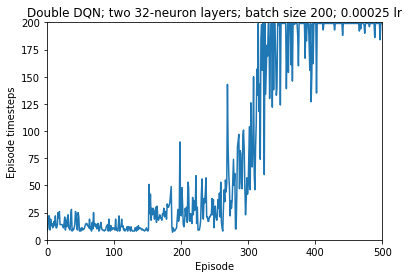

In [30]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(trainer.episode_lengths,label='episode length')
ax.set_xlabel('Episode')
ax.set_ylabel('Episode timesteps')
ax.set_title('Double DQN; two 32-neuron layers; batch size 32; Adam optimizer; 0.00025 lr')
ax.set_ylim(0, max_num_steps)
ax.set_xlim(0, len(trainer.episode_lengths))